In [1]:
import torch

In [2]:
from torch.cuda import get_device_name

get_device_name()

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [3]:
# loading the dataset
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

# Transform: convert the dataset + normalize to [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5),)
])



In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

100.0%
100.0%
100.0%
100.0%


In [5]:
full_dataset = ConcatDataset([train_dataset, test_dataset])

In [6]:
batch_size = 128
dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

print(f"Total images: {len(full_dataset)}")

Total images: 70000


In [10]:
import matplotlib.pyplot as plt

# Get one batch of images and labels
images, labels = next(iter(dataloader))


In [12]:
images = images * 0.5 + 0.5  # Since we normalized earlier with mean=0.5, std=0.5


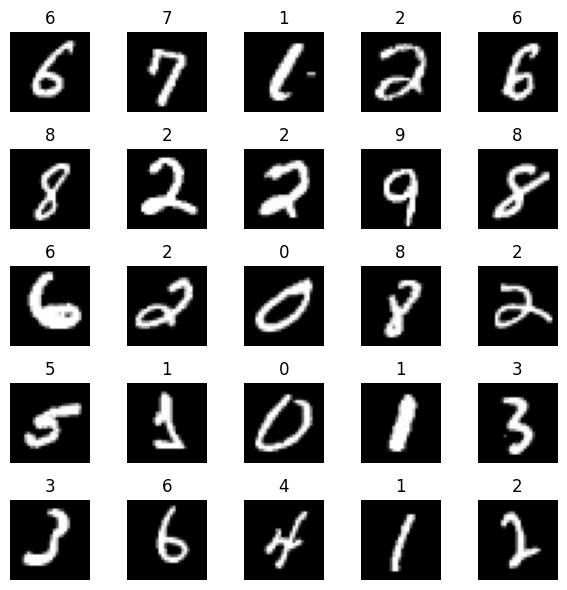

In [13]:
# Plot first 25 images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i][0], cmap='gray')  # [0] to drop the channel dim (1, 28, 28) → (28, 28)
    plt.title(f'{labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
import numpy as np

# Number of steps in the diffusion process
T = 1000

# Linear noise schedule from 1e-4 to 0.02
beta_start = 1e-4
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)


In [15]:
# Precalculate alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)   # product of alphas over time

In [16]:
# These are useful for the closed-form noise sampling
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

In [40]:
# Define the forward process
def forward_diffusion_sample(x_0, t, device='cuda:0'):
    """
    Takes an image and a timestampt t
    returns the noised version x_t and the noise used
    """
    noise = torch.randn_like(x_0).to(device)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].to(device)[:, None, None, None]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].to(device)[:None, None, None]

    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

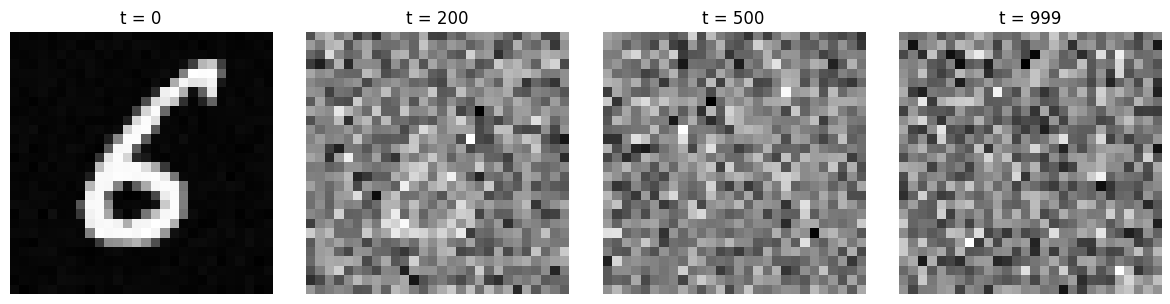

In [46]:
# Picking the first image from the dataset
image = images[0].unsqueeze(0).to('cuda:0')  

# picking some random timesteps to visualize how the diffusion process looks like
timesteps = torch.tensor([0, 200, 500, 999]).to('cuda:0')

plt.figure(figsize=(12, 3))
for idx, t in enumerate(timesteps):
    t_batch = torch.tensor([t])
    noisy_image, _ = forward_diffusion_sample(image, t_batch)
    noisy_image = noisy_image.squeeze().detach().cpu().numpy()
    
    plt.subplot(1, 4, idx + 1)
    plt.imshow(noisy_image, cmap='gray')
    plt.title(f"t = {t.item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import math
import torch.nn as nn

# Positional embedding which basically tells the UNet model 'at which position we at'
# It is used for the model to understand what a timestep exactly means and understand how close we are at from pure noise
# Nearby 't' have some sort of relation, that the x(t-1) is the previous step to x(t)
# If t=999, we are very far from diffusion and if t=10, we are close to recreating the original image
class SinusodialTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        # t: (batch,)
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:,None] * emb[None,:]   # shape (batch, half_dim)
        emb = torch.cat([torch.emb(emb), torch.cos(emb)], dim=1)
        return emb

In [48]:
import torch.nn.functional as F

# defining our UNet model
class SimpleUNet(nn.Module):
    def __init__(self, time_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusodialTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        # Encoder 
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        # Time embedding projection to feature map shape
        self.time_proj = nn.Linear(time_dim, 64)

        # Bottleneck
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)

        # Decoder
        self.deconv1 = nn.Conv2d(64, 32, 3, padding=1)
        self.deconv2 = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t):
        # Time embedding 
        t_emb = self.time_mlp(t)    # Shape: (B, time_dim)

        # Downsample 
        x = F.relu(self.conv1(x))   # (B, 32, 28, 28)
        x = F.relu(self.conv2(x))   # (B, 64, 28, 28)

        # Inject time embedding into spatial dimensions
        t_proj = self.time_proj(t_emb).view(-1, 64, 1, 1)   # (B, 64, 1, 1)
        x = x + t_proj

        # Bottleneck
        x = F.relu(self.conv3(x))

        # Upsample
        x = F.relu(self.deconv1(x))
        x = self.deconv2(x)

        return x
            